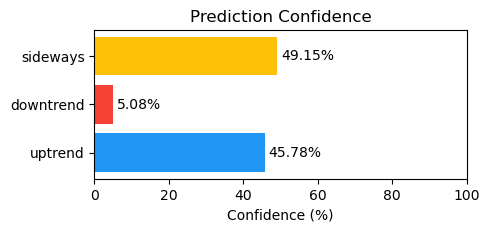

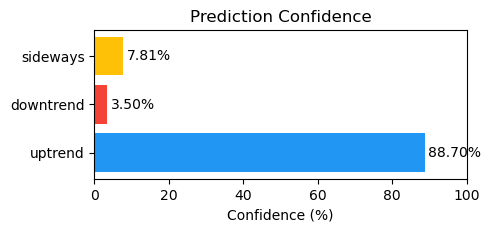

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import cv2
from skimage.metrics import structural_similarity as ssim

# Load your trained model
model = tf.keras.models.load_model("candlestick_model.keras")
categories = ["uptrend", "downtrend", "sideways"]

# SSIM-based candlestick detector
def is_candlestick_chart(image_path, reference_path="reference_candle.jpg"):
    try:
        img1 = cv2.imread(reference_path, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img1 is None or img2 is None:
            return False

        img1 = cv2.resize(img1, (224, 224))
        img2 = cv2.resize(img2, (224, 224))

        score, _ = ssim(img1, img2, full=True)
        return score > 0.4  # Adjust threshold if needed
    except Exception as e:
        print("SSIM error:", e)
        return False

# Predict trend from image
def predict_trend_from_image(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array, verbose=0)[0]
        predicted_class = np.argmax(prediction)
        probabilities = {cat: float(f"{prob * 100:.2f}") for cat, prob in zip(categories, prediction)}

        return categories[predicted_class], probabilities
    except Exception as e:
        return None, str(e)

# GUI class
class CandlestickPredictorGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Candlestick Trend Predictor")
        self.root.geometry("900x700")
        self.root.configure(bg="#f4f4f4")

        tk.Label(root, text="Upload a Candlestick Chart Image", font=("Arial", 16, "bold"), bg="#f4f4f4").pack(pady=10)

        tk.Button(root, text="Upload Image", font=("Arial", 12), bg="#4CAF50", fg="white",
                  command=self.upload_image).pack(pady=5)

        self.image_label = tk.Label(root, bg="#f4f4f4")
        self.image_label.pack(pady=10)

        self.result_var = tk.StringVar()
        tk.Label(root, textvariable=self.result_var, font=("Arial", 14, "bold"), bg="#f4f4f4").pack(pady=10)

        self.chart_frame = tk.Frame(root, bg="#f4f4f4")
        self.chart_frame.pack(pady=10)

    def upload_image(self):
        file_path = filedialog.askopenfilename(
            title="Select Candlestick Image",
            filetypes=[("Image files", "*.png *.jpg *.jpeg")]
        )
        if not file_path:
            return

        # Step 1: Check if it’s a valid candlestick chart
        if not is_candlestick_chart(file_path):
            messagebox.showwarning("Invalid Image", "This does not appear to be a valid candlestick chart.")
            return

        # Step 2: Run prediction
        trend, result = predict_trend_from_image(file_path)
        if trend is None:
            messagebox.showerror("Prediction Failed", result)
            return

        self.result_var.set(f"Predicted Trend: {trend.title()}")

        # Step 3: Show image
        img = Image.open(file_path)
        img.thumbnail((600, 300), Image.Resampling.LANCZOS)
        photo = ImageTk.PhotoImage(img)
        self.image_label.config(image=photo)
        self.image_label.image = photo

        # Step 4: Show confidence chart
        self.display_chart(result)

    def display_chart(self, probabilities):
        for widget in self.chart_frame.winfo_children():
            widget.destroy()

        fig, ax = plt.subplots(figsize=(5, 3))
        categories = list(probabilities.keys())
        values = list(probabilities.values())
        ax.barh(categories, values, color=["#2196F3", "#f44336", "#FFC107"])
        ax.set_xlim(0, 100)
        ax.set_xlabel("Confidence (%)")
        ax.set_title("Prediction Confidence")
        for i, v in enumerate(values):
            ax.text(v + 1, i, f"{v:.2f}%", va="center")
        plt.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=self.chart_frame)
        canvas.draw()
        canvas.get_tk_widget().pack()

# Run the application
if __name__ == "__main__":
    root = tk.Tk()
    app = CandlestickPredictorGUI(root)
    root.mainloop()